In [1]:
import os 
import zipfile 
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import cv2
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import shutil


In [2]:
!pip install kaggle

In [3]:

from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saimom","key":"fbf5b94989fa6ccceecc9a2091107c04"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d arunrk7/surface-crack-detection

 98% 228M/233M [00:01<00:00, 211MB/s]
100% 233M/233M [00:01<00:00, 198MB/s]


In [6]:
import zipfile 
local_dir='/content/surface-crack-detection.zip'
zip_ref=zipfile.ZipFile(local_dir,'r')
zip_ref.extractall('/tmp')
zip_ref.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/surface-crack-detection.zip' mode='r'>>

In [7]:
import os
for dirname, _, filenames in os.walk('/tmp'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

Streaming output truncated to the last 5000 lines.
/tmp/Positive/03132.jpg
/tmp/Positive/06914.jpg
/tmp/Positive/15431_1.jpg
/tmp/Positive/08166.jpg
/tmp/Positive/17872_1.jpg
/tmp/Positive/12027_1.jpg
/tmp/Positive/15307_1.jpg
/tmp/Positive/18997_1.jpg
/tmp/Positive/18651_1.jpg
/tmp/Positive/16979_1.jpg
/tmp/Positive/15553_1.jpg
/tmp/Positive/16958_1.jpg
/tmp/Positive/10151_1.jpg
/tmp/Positive/10870_1.jpg
/tmp/Positive/15948_1.jpg
/tmp/Positive/03358.jpg
/tmp/Positive/03330.jpg
/tmp/Positive/09862.jpg
/tmp/Positive/12557_1.jpg
/tmp/Positive/16988_1.jpg
/tmp/Positive/05396.jpg
/tmp/Positive/14688_1.jpg
/tmp/Positive/11640_1.jpg
/tmp/Positive/14328_1.jpg
/tmp/Positive/11848_1.jpg
/tmp/Positive/01664.jpg
/tmp/Positive/02633.jpg
/tmp/Positive/16896_1.jpg
/tmp/Positive/11725_1.jpg
/tmp/Positive/07616.jpg
/tmp/Positive/11114_1.jpg
/tmp/Positive/01235.jpg
/tmp/Positive/15986_1.jpg
/tmp/Positive/17324_1.jpg
/tmp/Positive/07582.jpg
/tmp/Positive/17670_1.jpg
/tmp/Positive/02178.jpg
/tmp/Positive

In [8]:
Root = '/tmp/'
TRAIN_PATH = 'train'
os.mkdir(TRAIN_PATH)

In [9]:
def processImages(folder_name):
  src = Root + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH)  

In [10]:
processImages('Negative')
print('N Done')
processImages('Positive')
print('P Done')

N Done
P Done


In [11]:
lr = 0.01
epochs = 2
batch_size = 20
input_size, output_size = 28 * 28, 2
hidden_size = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print(datasets)

Using cuda device
<module 'torchvision.datasets' from '/usr/local/lib/python3.7/dist-packages/torchvision/datasets/__init__.py'>


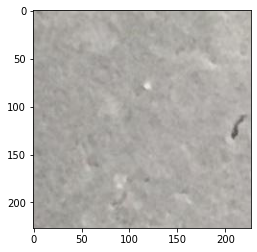

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('/tmp/Negative/00001.jpg'))

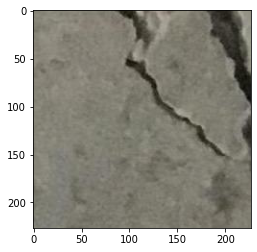

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.imshow(mpimg.imread('/tmp/Positive/00088.jpg'))

In [14]:
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()])

dataset = datasets.ImageFolder(root='/tmp', transform=transform)

train, test = torch.utils.data.random_split(dataset, [35000, 5000])


print(len(train))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)


print(len(test))
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)



35000
5000


In [15]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, hidden_size)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()


        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)

        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [16]:
model = DeepNeuralNetworkModel(input_size, hidden_size, output_size)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.7057687044143677. Accuracy: 50.86
Iteration: 1000. Loss: 0.695629358291626. Accuracy: 60.8
Iteration: 1500. Loss: 0.662356972694397. Accuracy: 69.6
Iteration: 2000. Loss: 0.5560299158096313. Accuracy: 75.5
Iteration: 2500. Loss: 0.5675601959228516. Accuracy: 76.14
Iteration: 3000. Loss: 0.4911067485809326. Accuracy: 78.14
Iteration: 3500. Loss: 0.4163835048675537. Accuracy: 81.54


[0.6380245089530945, 0.6586747169494629, 0.6534500122070312, 0.5474874973297119, 0.572144627571106, 0.6754962205886841, 0.45199424028396606]


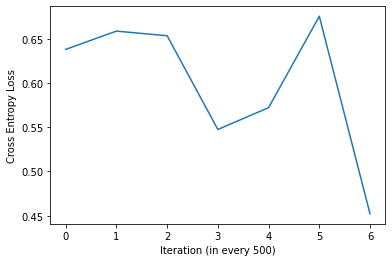

In [49]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Setting 2**

In [39]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

         # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [40]:
model = DeepNeuralNetworkModel(input_size, hidden_size, output_size)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [43]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.6741297841072083. Accuracy: 50.52
Iteration: 1000. Loss: 0.7008612751960754. Accuracy: 50.52
Iteration: 1500. Loss: 0.6922122240066528. Accuracy: 50.52
Iteration: 2000. Loss: 0.6941593289375305. Accuracy: 50.52
Iteration: 2500. Loss: 0.6946307420730591. Accuracy: 50.52
Iteration: 3000. Loss: 0.7086817026138306. Accuracy: 49.48
Iteration: 3500. Loss: 0.6938295364379883. Accuracy: 50.52


[0.6741297841072083, 0.7008612751960754, 0.6922122240066528, 0.6941593289375305, 0.6946307420730591, 0.7086817026138306, 0.6938295364379883]


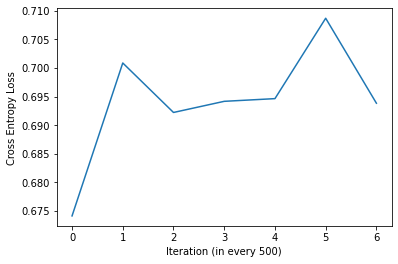

In [44]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Setting 3**

In [50]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.LeakyReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.LeakyReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.LeakyReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)

         # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [51]:
model = DeepNeuralNetworkModel(input_size, hidden_size, output_size)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [52]:
'''
TRAIN THE MODEL
'''

iteration_loss = []
iter = 0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.7045584321022034. Accuracy: 50.52
Iteration: 1000. Loss: 0.6583526730537415. Accuracy: 70.22
Iteration: 1500. Loss: 0.6709427833557129. Accuracy: 72.86
Iteration: 2000. Loss: 0.5951197743415833. Accuracy: 75.7
Iteration: 2500. Loss: 0.3933437466621399. Accuracy: 72.82
Iteration: 3000. Loss: 0.33088022470474243. Accuracy: 84.38
Iteration: 3500. Loss: 0.38664984703063965. Accuracy: 84.74


[0.7045584321022034, 0.6583526730537415, 0.6709427833557129, 0.5951197743415833, 0.3933437466621399, 0.33088022470474243, 0.38664984703063965]


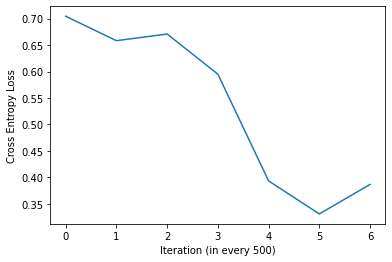

In [53]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

**Setting 4**

In [43]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, x):
        logits  = self.linear(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas

In [44]:
'''
INSTANTIATE MODEL CLASS
'''
model = LogisticRegressionModel(input_size=input_size,
                                num_classes=output_size)
# To enable GPU
model.to(device)

LogisticRegressionModel(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [46]:
'''
TRAIN THE MODEL
'''
iteration_loss = []
iter = 0
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        logits, probas = model(images) 

        # Calculate Loss: PyTorch implementation of CrossEntropyLoss works with logits, not probabilities
        loss = F.cross_entropy(logits, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                logits, probas = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(probas, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 0.8636872172355652. Accuracy: 83.34
Iteration: 1000. Loss: 0.27723854780197144. Accuracy: 88.84
Iteration: 1500. Loss: 0.2528038024902344. Accuracy: 87.68
Iteration: 2000. Loss: 0.3854047358036041. Accuracy: 86.1
Iteration: 2500. Loss: 0.24164772033691406. Accuracy: 84.66
Iteration: 3000. Loss: 0.7131980061531067. Accuracy: 86.08
Iteration: 3500. Loss: 0.41800785064697266. Accuracy: 87.46


[0.4851626455783844, 0.49526333808898926, 0.2595520317554474, 0.16067084670066833, 0.6350005865097046, 0.07235962897539139, 0.16262570023536682]


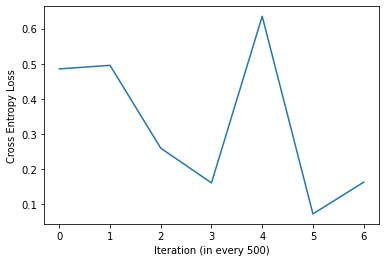

In [58]:
import matplotlib
import matplotlib.pyplot as plt

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

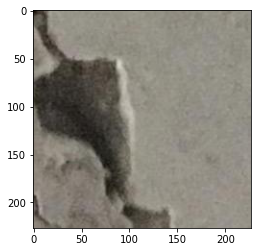

In [60]:

img=Image.open('/content/train/00108.jpg')
plt.imshow(img)